# Resource Estimation

## RSA

At MIT, in 1977, [Ron **R**ivest](https://en.wikipedia.org/wiki/Ron_Rivest), [Adi **S**hamir](https://en.wikipedia.org/wiki/Adi_Shamir), and [Leonard **A**dleman](https://en.wikipedia.org/wiki/Leonard_Adleman) introduced the [RSA](https://en.wikipedia.org/wiki/RSA_(cryptosystem)) cryptosystem. Today, their encryption algorithm sees wide-ranging applications; securing emails, network traffic in VPNs, and even your bank account transactions.

Given its uses in such sensitive domains, one would think that RSA is unbreakable; perhaps its inner workings are kept secret so no one can find out its vulnerabilites, or maybe it's just too complex for anyone to understand. Surprisingly, RSA's implementation is neither secret nor complex, and the algorithm that breaks it has been known since the day RSA was introduced.

In fact, we can write that algorithm ourselves. At the heart of RSA is a known composite number, $r$, that has exactly two unknown prime factors, $p$ and $q$. All we need to decrypt an RSA-encrypted ciphertext is to find $p$ and $q$.

In [1]:
def factorize(r: int) -> tuple[int, int]:
	"""
	Factorizes the input into its two prime factors.

	Parameters
	----------
	r
		The number to factorize.
		Must be a positive composite integer that has exactly two prime factors.

	Returns
	-------
	tuple[int, int]
		The two prime factors of the input number.

	Raises
	------
	ValueError
		If the input is prime.
	"""
	from math import floor, sqrt

	# We handle the case of 𝑝 = 2 separately to optimize future steps
	if r % 2 == 0:
		p = 2
		q = r // 2
		return (p, q)

	# 𝑝 > 2 because we already checked if 𝑟 was an even number
	lower_limit = 2 + 1

	# 𝑝 < ⌊√𝑟⌋ + 1 because 𝑟 cannot have factors larger than √𝑟
	upper_limit = floor(sqrt(r)) + 1

	# 𝑝 is prime ⇒ 𝑝 is not an even number
	# ∴ we can take steps of size 2, if we start from 3
	step_size = 2

	for p in range(lower_limit, upper_limit, step_size):
		if r % p == 0:
			q = r // p
			return (p, q)

	# Exiting loop without finding a factor ⇒ 𝑟 is prime
	raise ValueError("r is prime")

To test our code, let's assume $p = 13$ and $q = 41$. Thus, $r = pq = 13 \cdot 41 = 533$.

Additionally, we will time our code to see how long it takes to find $p$ and $q$.

In [2]:
from lib import time, sci

r = 533
time_taken = time(lambda: factorize(r))
(p, q) = factorize(r)

print(f"Factorized {r} into {p} and {q} in {sci(f"{time_taken:.2e}")} s.")

Factorized 533 into 13 and 41 in 4.55·10⁻⁷ s.


On most modern computers, factorizing $533$ takes less than a microsecond. That sounds like bad news for RSA, but we should try a few more numbers before coming to any conclusions.

Let's now take increasingly larger numbers and factorize them to see how long it takes.

In [3]:
numbers = [
	6,
	55,
	533,
	4_343,
	31_937,
	689_147,
	6_660_079,
	85_579_567,
	# 155_740_867,
	# 1_561_263_047,
	# 52_731_823_219,
	# 268343_805_029,
]

for r in numbers:
	time_taken = time(lambda: factorize(r))
	(p, q) = factorize(r)
	print(f"(⏳ {sci(f"{time_taken:.2e}")} s) {r} = {p}·{q}")

(⏳ 5.40·10⁻⁷ s) 6 = 2·3
(⏳ 3.22·10⁻⁷ s) 55 = 5·11
(⏳ 3.63·10⁻⁷ s) 533 = 13·41
(⏳ 6.19·10⁻⁷ s) 4343 = 43·101
(⏳ 1.66·10⁻⁶ s) 31937 = 109·293
(⏳ 7.78·10⁻⁶ s) 689147 = 683·1009
(⏳ 2.46·10⁻⁵ s) 6660079 = 1523·4373
(⏳ 6.23·10⁻⁴ s) 85579567 = 8501·10067


As we might have expected, larger numbers take more time to factorize, but we still only need a few milliseconds for numbers as big as 50 billion. Just how big should $r$ be so that our algorithm takes an _unreasonably_ long time to factorize it?

One way to answer that question is to plot the empirical data we have collected against some measure of how "big" $r$ is. In algorithm analysis, we often do not care about the _value_ of the input, but rather its _size_—usually, this means the length of the string representation of the input.

In our case, we'll plot the time taken to factorize $r$ on the $y$-axis, and the number of digits in $r$ on the $x$-axis.

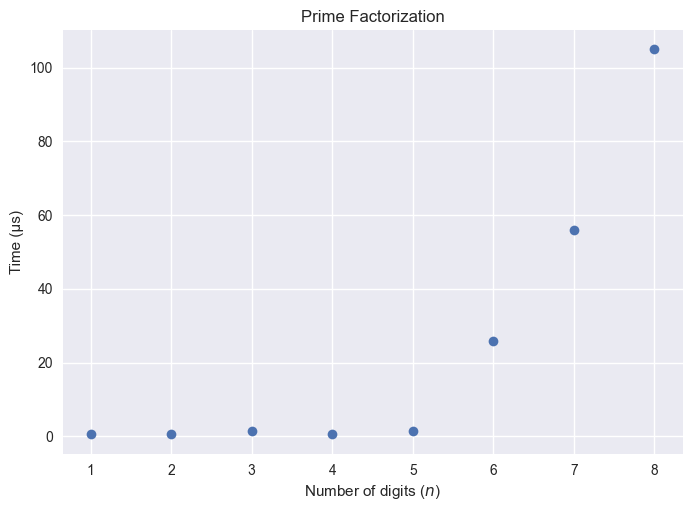

In [4]:
from lib import plot

plot(
	x = [len(str(r)) for r in numbers],
	y = [time(lambda: factorize(r)) * 1e6 for r in numbers],
	x_label = "Number of digits ($n$)",
	y_label = "Time (μs)",
	title = "Prime Factorization",
)

Finally, we see _why_ RSA is so secure. The time taken to factorize $r$ grows _exponentially_ with the number of digits in $r$, and modern RSA keys are over 600 digits long!

What we have just done was a form of _resource estimation_—we estimated the resources (in this case, time—we will see other metrics later) required to break RSA. This is a powerful tool in computer science, as it allows us to understand the limits of our algorithms and systems. Simply having an algorithm that works is not enough; we must also know _how well_ it works.

## Hardware Considerations

The theoretical time complexity of an algorithm is a good starting point, but it is not the whole story. In practice, the hardware on which the algorithm runs can have a significant impact on its performance.

We will now look at an interesting case study comparing linked lists and arrays in the implementation of an algorithm proposed by [Jon Bentley](https://en.wikipedia.org/wiki/Jon_Bentley_(computer_scientist)). While the choice of data structure has theoretical implications, we will see that "irrelevant" factors like the programming language and details of the hardware / architecture can have a significant impact on the decision of choosing an implementation.

### The Algorithm

---
1. Generate $n$ random integers.
2. Insert them into a sequence in numerical order.  
For example, if our random integers were $5$, $1$, $4$, and $2$, the sequence would grow as follows:  
	* $5$
	* $1$, $5$
	* $1$, $4$, $5$
	* $1$, $2$, $4$, $5$
3. Remove elements from the sequence, one at a time, choosing the element to remove at random.  
For example, if we chose to remove the elements in the order $2$, $5$, $1$, and $4$, the sequence would shrink as follows:  
	* $1$, $2$, $4$, $5$
	* $1$, $4$, $5$
	* $1$, $4$
	* $4$
4. Halt when the sequence is empty.
---

We have a sequence that grows and shrinks, while keeping the elements in numerical order. Doing so requires us to insert and delete elements in the middle of the sequence, so we will consider two implementations: one using a **linked list** and the other using an **array**. Let's quickly review these data structures to see what they are good at.

### Arrays

An array is a data structure that stores a fixed-size collection of elements of the same type. The elements are stored in contiguous memory locations, which allows for fast access to individual elements. However, inserting or deleting elements in the middle of an array can be slow, as it requires shifting all subsequent elements.

![Array](./assets/array.png)

In [5]:
from lib.array import Array

array = Array(1, 2, 3)
array.insert(0, 0)
print(array)

╭───╮╭───╮╭───╮╭───╮
│ 0 ││ 1 ││ 2 ││ 3 │
╰───╯╰───╯╰───╯╰───╯


### Linked Lists

A linked list is a data structure that consists of nodes, where each node contains a value and a reference to the next node in the list. This structure allows for efficient insertion and deletion of elements, as it does not require shifting elements in memory. However, accessing individual elements in a linked list can be slower than in an array, as it requires traversing the list from the beginning.

![List](./assets/list.png)

In [9]:
from lib.list import List

next = List.Node(1)
previous = List.Node(1)
node = List.Node(0, previous, next)

print(node)

╭───╮╭-╮ 
│ 0 │ ·←
╰───╯╰-╯ 


### A Counterintuitive Comparison

Consider the following algorithm:

Since the algorithm involves lots of insertions and deletions, we might expect a linked list to outperform an array. However, the situation is more nuanced than it seems. In this tutorial, we will analyze the resource requirements of this algorithm for both arrays and linked lists.

In [7]:
# Ask the students for their implementation; might use it to benchmark against the solution

def student_solution():
	pass

#### Time Complexity

We will now attempt to estimate the time complexity of the algorithm for both arrays and linked lists.

Step 1 involves generating $n$ random integers, which can be done in $O(n)$ time for both arrays and linked lists. Therefore, we do not need to include this step in our analysis.

Steps 2 and 3 involve first finding the correct position before insertion / deletion can take place. To keep things fair, we will make both arrays and linked lists perform linear search to find the correct position. This operation will take $O(n)$ time for both arrays and linked lists.

That leaves only the insertion and deletion steps to consider. Let's analyze the time complexity of these steps for both arrays and linked lists.

#### Array Implementation Complexity

To calculate the complexity of the algorithm when using an array, we need to consider the time required for inserting and deleting elements. Inserting an element into an array of size $n$ requires $O(n)$ time, as we may need to shift all subsequent elements. Deleting an element from an array also requires $O(n)$ time, as we may need to shift all subsequent elements. Therefore, the total time complexity of the algorithm when using an array is $O(n^2)$.

#### Linked List Implementation Complexity

To calculate the complexity of the algorithm when using a linked list, we need to consider the time required for inserting and deleting elements. Inserting an element into a linked list of size $n$ requires $O(n)$ time, as we may need to traverse the list to find the correct position. Deleting an element from a linked list also requires $O(n)$ time, as we may need to traverse the list to find the element to delete. Therefore, the total time complexity of the algorithm when using a linked list is $O(n^2)$.

 In theory, both arrays and linked lists have the same time complexity for this algorithm. However, in practice, arrays may outperform linked lists due to cache locality and other hardware-specific optimizations. In this tutorial, we will compare the performance of arrays and linked lists for this algorithm using Python.

In [8]:
# Benchmarks and plots of the array v linked list solution
# Help the students see the different O(n^2) curves.

### Bjarne Stroustrup C++ Results

[Video link](https://youtu.be/YQs6IC-vgmo?si=0U3VzesKsXyhNPCT)

![C++](./assets/vector-list-perf.png)

Finally, we show the shocking result from C++, where arrays always beat linked lists. This is due to the fact that the C++ standard library implementation of `std::vector` is highly optimized on modern CPU hardware, effectively utilizing caches and memory prefetching to outperform linked lists.